# Vineyard Classificator

**Objective**: the aim of this notebook is to train multiple classificators with images coming from vineyards. The best trained classificator, in term of performance and accuracy, will be used to control a robot with the probability of the predictions. So, it's a classification tasks with three dinstinct classes, left, center and right.

**Models**: A model based approach with Deep Learning algorithms will be exploit. In particular, a technique dubbed transfer learning (fine tuning) will be applied in order to re-train network already trained on ImageNet dataset. This will not only let achieve higher performances, but also will tackle the lack of a large dataset.

**Architecture**: 
   - MobileNet (ncs1 & ncs2 compatible)
   - Inception-v3 (ncs1 & ncs2 compatible)
   - Xception (Xavier compatible)
   - InceptionResNetV2 (ncs2 compatible)
   
   
**Papers**:
    - Autonomous Navigation in Vineyards with Deep Learning at the Edge: (https://link.springer.com/chapter/10.1007/978-3-030-48989-2_51)
    - Local Motion Planner for Autonomous Navigation in Vineyards with a RGB-D Camera-Based Algorithm and Deep Learning Synergy (

# 1.0 Import the dataset

In [1]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf

In [2]:
#configure your GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
PATH_DIR = os.path.abspath('.')
dataset_dir = os.path.join(PATH_DIR, 'dataset')
train_dir = os.path.join(dataset_dir, 'train')
validation_dir =  os.path.join(dataset_dir, 'validation')
test_dir =  os.path.join(dataset_dir, 'test')

# Parameters
batch_size = 64
img_sz = (224, 224) # must be equal to the choosen network
classes = ['left', 'center', 'right'] #output classes

In [4]:
# Data Augmentation Parameters
z_range = 0.1 # zoom
b_range = [1.0, 0.4] # brightenss

# create two datagenerator for the train and test set
train_image_generator = ImageDataGenerator(rescale = 1./255,
                                  zoom_range = z_range,
                                  brightness_range = b_range,
                                  fill_mode = 'nearest')
validation_image_generator = ImageDataGenerator(rescale = 1./255)
test_image_generator = ImageDataGenerator(rescale = 1./255)
test_casa_image_generator = ImageDataGenerator(rescale = 1./255)

In [5]:
# create two generators
train_data_gen = train_image_generator.flow_from_directory(directory = train_dir,
                                                          batch_size = batch_size,
                                                          classes = classes,
                                                          shuffle = False, # only for testing
                                                          target_size = img_sz,
                                                          class_mode = 'categorical', # it means labels are [1,0,0]
                                                          seed = 3)
validation_data_gen = test_image_generator.flow_from_directory(directory = validation_dir,
                                                        batch_size = batch_size,
                                                        classes = classes,
                                                        shuffle = False,
                                                        seed=3,
                                                        target_size = img_sz,
                                                        class_mode = 'categorical')
test_data_gen = test_image_generator.flow_from_directory(directory = test_dir,
                                                        batch_size = batch_size,
                                                        classes = classes,
                                                        shuffle = False,
                                                        seed=3,
                                                        target_size = img_sz,
                                                        class_mode = 'categorical')

Found 23530 images belonging to 3 classes.
Found 5042 images belonging to 3 classes.
Found 5044 images belonging to 3 classes.


In [6]:
# plot class relations
train_data_gen.class_indices

{'left': 0, 'center': 1, 'right': 2}

# 2.0 Plot the dataset

In [ ]:
def plotImages(images_batch, img_n, classes):
    """
    Take as input a batch from the generator and plt a number of images equal to img_n
    Default columns equal to max_c. At least inputs of batch equal two
    """
    max_c = 5
    
    if img_n <= max_c:
        r = 1
        c = img_n
    else:
        r = math.ceil(img_n/max_c)
        c = max_c
        
    fig, axes = plt.subplots(r, c, figsize=(15,15))
    axes = axes.flatten()
    for img_batch, label_batch, ax in zip(images_batch[0], images_batch[1], axes):
        ax.imshow(img_batch)
        ax.grid()
#    _ = plt.suptitle("Batch images", verticalalignment='top')
        ax.set_title('Class: {}'.format(classes[np.argmax(label_batch)]))
    plt.tight_layout()
    plt.show()

In [ ]:
plotImages(next(train_data_gen), 5, classes)

# 3.0 Fine-Tune Selected Models

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from datetime import datetime

In [8]:
model_dir = os.path.join(PATH_DIR, 'bin')

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [9]:
def buildModel(base_model, first_layer = 1024, output = 3):
    """Add two fully connected layers to the base model
    """
    
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(first_layer, activation='relu')(x)

    predictions = Dense(output, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

In [10]:
def plotHistory(history):
    """
    Plot the loss and accuracy curves for training and validation 
    """
    fig, ax = plt.subplots(2,1, figsize=(20,15))
    ax[0].plot(history.history['loss'], color='b', label="Training loss")
    ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
    ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)

In [11]:
# Define the optimizer
optimizer_r = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
optimizer_a = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)

In [12]:
# Load model if needed
from tensorflow.keras.models import load_model

model = load_model('bin/MobileNet_final_retrained.h5')

## 3.1 MobileNet

In [ ]:
name = 'MobileNet_final'
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "logs"
logdir = "{}/run-{}_{}/".format(root_logdir, now,name)

backup_model_path = os.path.join(model_dir, '{}_retrained.h5'.format(name)) # it contains already the weights
backup_weights_path = os.path.join(model_dir, '{}_retrained_weights.h5'.format(name))

# tensorboard
tensorboard = TensorBoard(log_dir = logdir)

checkpointer = ModelCheckpoint(filepath=backup_weights_path, 
                               monitor = 'loss',
                               verbose=1, 
                               save_best_only=True)

In [ ]:
from keras.applications.mobilenet import MobileNet

# create the base pre-trained model
base_model = MobileNet(input_shape = (224, 224, 3),
                       weights='imagenet', include_top=False,
                       alpha=1.0, depth_multiplier=1, dropout=1e-3)

model = buildModel(base_model, 256, 3)

In [ ]:
# plot the summary
model.summary()

In [ ]:
# for i, layer in enumerate(model.layers):
#    print(i, layer.name)
# print the depth of the network
model_depth = len(model.layers)
print("Depth of the network: {}".format(model_depth))

### 3.1.1 Re-Train the network

In [ ]:
# i.e. freeze all base model layers
for layer in base_model.layers:
    layer.trainable = True

In [ ]:
# compile the model 
model.compile(optimizer=optimizer_r, loss='categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
first_n_epochs = 6

# train the model on the new data for a few epochs
history = model.fit_generator(train_data_gen, ((train_data_gen.n // batch_size) + 1),
                    epochs = first_n_epochs,
                    validation_data = validation_data_gen, shuffle = True,
                    validation_steps = ((validation_data_gen.n // batch_size) + 1),
                    callbacks = [tensorboard])

In [ ]:
plotHistory(history)

In [ ]:
# save model and weights
model.save(backup_model_path)
model.save_weights(backup_weights_path)

### 3.1.2 Test the retrained model

In [ ]:
score = model.evaluate_generator(train_data_gen, steps = (train_data_gen.n // batch_size + 1),  workers=10)

In [ ]:
for s, m in zip(score, model.metrics_names):
    print("{}: {}".format(m, s))

- MobileNet_second (grugliasco training) **test** new 5044 ==> acc: 0.9484536082474226 loss: 0.4985503224651601
- MobileNet_second (grugliasco training) **train** new 23530 ==> acc: 0.9408839778600223 loss: 0.5127158542301014
- MobileNet_second (grugliasco training) **validation** new 5042 ==> acc: 0.9430781435938119 loss: loss: 0.5145192529085608

### 3.1.3 Confusion Matrix

In [ ]:
import itertools
# defining the confusion matrix function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

In [ ]:
# collect test predictions
y_pred = model.predict_generator(train_data_gen, steps = ((train_data_gen.n // batch_size) + 1), workers=10)

In [ ]:
# predicting with the classifier
cm = confusion_matrix(train_data_gen.classes, np.argmax(y_pred, axis=-1))

plot_confusion_matrix(cm, classes, title = 'Confusion Matrix')

### 3.1.4 Classifiction Report

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
accuracy_score(train_data_gen.classes, np.argmax(y_pred, axis=-1))

In [ ]:
labels = list((train_data_gen.class_indices).values())
target_names = list((train_data_gen.class_indices).keys())

In [ ]:
clf_report = classification_report(train_data_gen.classes, np.argmax(y_pred, axis=-1),
                      labels=labels, target_names=target_names, digits=3)
print(clf_report)

## 3.2 Plot Intermediate Layers

In [ ]:
import cv2

In [ ]:
FIRST_IMAGE = cv2.resize(cv2.cvtColor(cv2.imread('dataset/train/left/img_0.jpg') , cv2.COLOR_BGR2RGB), (224,224))/255.0
SECOND_IMAGE = cv2.resize(cv2.cvtColor(cv2.imread('dataset/train/center/img_20.jpg') , cv2.COLOR_BGR2RGB), (224,224))/255.0
THIRD_IMAGE = cv2.resize(cv2.cvtColor(cv2.imread('dataset/train/right/img_0.jpg') , cv2.COLOR_BGR2RGB), (224,224))/255.0

from tensorflow.keras import models
layer_outputs = [layer.output for layer in model.layers]

In [ ]:
for i,j in enumerate(layer_outputs):
    print(i, j)

In [ ]:
selected_layers = [layer_outputs[2], layer_outputs[28], layer_outputs[84]]

In [ ]:
selected_layers

In [ ]:
activation_model = Model(inputs = model.input, outputs = selected_layers)

In [ ]:
CONVOLUTION_NUMBER = 6
fig, ax = plt.subplots(3,4, figsize=(15,15))


ax[0,0].imshow(FIRST_IMAGE)
#ax[0,0].axis('off')
#ax[0,0].grid(True)
ax[1,0].imshow(SECOND_IMAGE)
#ax[1,0].axis('off')
#ax[1,0].grid(True)
ax[2,0].imshow(THIRD_IMAGE)
#ax[2,0].axis('off')
#ax[2,0].grid(True)   


for x in range(0, 3):
    f1 = activation_model.predict(FIRST_IMAGE.reshape(1,224,224,3))[x]
    ax[0,x+1].imshow(f1[0,:,:,CONVOLUTION_NUMBER], cmap='inferno')
    ax[0,x+1].grid(False)
    
    f2 = activation_model.predict(SECOND_IMAGE.reshape(1,224,224,3))[x]
    ax[1,x+1].imshow(f2[0,:,:,CONVOLUTION_NUMBER], cmap='inferno')
    ax[1,x+1].grid(False)
    
    f3 = activation_model.predict(THIRD_IMAGE.reshape(1,224,224,3))[x]
    ax[2,x+1].imshow(f3[0,:,:,CONVOLUTION_NUMBER], cmap='inferno')
    ax[2,x+1].grid(False)
plt.tight_layout()
plt.subplots_adjust(bottom=1.0, top=1.7, hspace=0.1)
plt.savefig('activations_layers_2_28_84.png', dpi=300)
plt.show()

## 3.3 Use GradCAM

Using GradCAM for a better understanding of where the network focuses 


In [13]:
from tf_explain.core.grad_cam import GradCAM

In [14]:
explainer = GradCAM()

In [ ]:
x_test, y_test = next(test_data_gen)

In [ ]:
y_pred = model.predict(x_test)

In [17]:
def explainGradCam(explainer, model, img, y, y_pred, class_names):
    data = data = ([img], None)
    plt.figure(figsize=(5,5))
    y = np.argmax(y)
    y_predm = np.argmax(y_pred)
    if y == y_predm:
        color = 'blue'
    else:
        color = 'red'
        
    grid = explainer.explain(data, model, class_index=y_predm, colormap=14) 

    plt.imshow(grid)

    plt.show()


In [75]:
index = 0

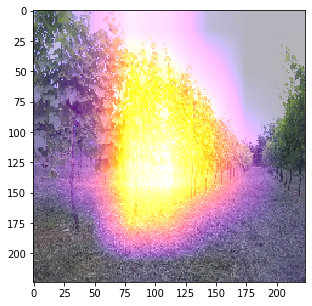

In [129]:
figure_n = index # number of figure (64)
index += 1
explainGradCam(explainer, model, x_test[figure_n], y_test[figure_n],
               y_pred[figure_n], class_names=list(train_data_gen.class_indices.keys()))

## 3.2 Xception

In [ ]:
name = 'Xception'
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "logs"
logdir = "{}/run-{}_{}/".format(root_logdir, now,name)

backup_model_path = os.path.join(model_dir, '{}_retrained.h5'.format(name)) # it contains already the weights
backup_weights_path = os.path.join(model_dir, '{}_retrained_weights.h5'.format(name))

# tensorboard
tensorboard = TensorBoard(log_dir = logdir)

checkpointer = ModelCheckpoint(filepath=backup_weights_path, 
                               monitor = 'loss',
                               verbose=1, 
                               save_best_only=True)

In [ ]:
from keras.applications.xception import Xception

# create the base pre-trained model
base_model = Xception(input_shape = (299, 299, 3),
                       weights='imagenet', include_top=False)

model = buildModel(base_model, 256, 3)

In [ ]:
# plot the summary
model.summary()

In [ ]:
# for i, layer in enumerate(model.layers):
#    print(i, layer.name)
# print the depth of the network
model_depth = len(model.layers)
print("Depth of the network: {}".format(model_depth))

### 3.2.1 Train only the head of the network

In [ ]:
# i.e. freeze all base model layers
for layer in base_model.layers:
    layer.trainable = True

In [ ]:
# compile the model 
model.compile(optimizer=optimizer_r, loss='categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
first_n_epochs = 5

# train the model on the new data for a few epochs
history = model.fit_generator(train_data_gen, ((train_data_gen.n // batch_size) + 1),
                    epochs = first_n_epochs,
                    validation_data = validation_data_gen, shuffle = True,
                    validation_steps = ((validation_data_gen.n // batch_size) + 1),
                    callbacks = [tensorboard, checkpointer])

In [ ]:
plotHistory(history)

In [ ]:
# save model and weights
model.save(backup_model_path)
model.save_weights(backup_weights_path)

## 3.3 MobileNetv2

In [ ]:
name = 'MobileNetv2'
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "logs"
logdir = "{}/run-{}_{}/".format(root_logdir, now,name)

backup_model_path = os.path.join(model_dir, '{}_retrained.h5'.format(name)) # it contains already the weights
backup_weights_path = os.path.join(model_dir, '{}_retrained_weights.h5'.format(name))

# tensorboard
tensorboard = TensorBoard(log_dir = logdir)

checkpointer = ModelCheckpoint(filepath=backup_weights_path, 
                               monitor = 'loss',
                               verbose=1, 
                               save_best_only=True)

In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2

# create the base pre-trained model
base_model = MobileNetV2(input_shape = (224, 224, 3),
                       weights='imagenet', include_top=False)

model = buildModel(base_model, 512, 3)

In [ ]:
# plot the summary
model.summary()

In [ ]:
# for i, layer in enumerate(model.layers):
#    print(i, layer.name)
# print the depth of the network
model_depth = len(model.layers)
print("Depth of the network: {}".format(model_depth))

### 3.3.1 Train only the head of the network

In [ ]:
# i.e. freeze all base model layers
for layer in base_model.layers:
    layer.trainable = True

In [ ]:
# compile the model 
model.compile(optimizer=optimizer_r, loss='categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
first_n_epochs = 3

# train the model on the new data for a few epochs
history = model.fit_generator(train_data_gen, ((train_data_gen.n // batch_size) + 1),
                    epochs = first_n_epochs,
                    validation_data = validation_data_gen, shuffle = True,
                    validation_steps = ((validation_data_gen.n // batch_size) + 1),
                    callbacks = [tensorboard, checkpointer])

In [ ]:
plotHistory(history)

In [ ]:
# save model and weights
model.save(backup_model_path)
model.save_weights(backup_weights_path)

### 3.3.2 Test the retrained model

In [ ]:
score = model.evaluate_generator(test_data_gen, steps = (test_data_gen.n // batch_size + 1))

In [ ]:
for s, m in zip(score, model.metrics_names):
    print("{}: {}".format(m, s))

# 4.0 Test the model on a new dataset

In [ ]:
score = model.evaluate_generator(test_data_gen, steps = (test_data_gen.n // batch_size + 1))

In [ ]:
for s, m in zip(score, model.metrics_names):
    print("{}: {}".format(m, s))

In [ ]:
y_pred = model.predict_generator(test_casa_data_gen, steps = ((test_casa_data_gen.n // batch_size) + 1))

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(np.argmax(y_test, axis=-1), np.argmax(y_pred, axis=-1))

In [ ]:
# predicting with the classifier
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(y_pred, axis=-1))

plot_confusion_matrix(cm, classes, title = 'Confusion Matrix')

# 5.0 Test models on single images

In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input, decode_predictions
import numpy as np

file = 'frame_0.jpg'

img_path = os.path.join(dataset_dir, test_casa_dir, 'left', file)
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = model.predict(x)

plt.title('Predicted: {}'.format(classes[np.argmax(y)]))
_ = plt.imshow(img)